# EDA: Check if jawiki edits correlate with time:
(Weekends, time of day, Japanese holidays, lagged edits.)

## Import and Clean

### Imports and working directory

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import datetime
from zoneinfo import ZoneInfo
from dateutil.tz import gettz
from dateutil.parser import isoparse
# from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

In [2]:
# Use the notebooks directory containing this notebook as working directory
home_path = str(Path.home())
os.chdir(home_path + '/git/predwikt/notebooks')

### Get the wiki data in pandas

In [3]:
# Get the schema description & column names (see 1.02 for more detail)
schema_df = pd.read_csv('../data/external/mediawiki_history_schema.tsv', delimiter='\t')
mw_hist_colnames = list(schema_df.col_name)[:-1]
usecols = ['event_entity', 'event_timestamp', 
           'event_user_is_bot_by_historical', 'revision_id']

**Selection of columns:**
- Only picked the necessary columns to:
    - Drop bot edits (event_user_is_bot_by_historical)
    - Select only "revision-type" edits (event_entity)
    - Keep a meaningful index (revision_id)
    - Timestamp (event_timestamp)

In [4]:
# Get Data
df = pd.read_csv('../data/raw/2021-10.jawiki.2021.tsv', 
                 delimiter='\t', names=mw_hist_colnames, header=None, usecols=usecols
                 ) # ,nrows=1000000
# Remove bot records
df = df[df.event_user_is_bot_by_historical.isna()]
# Keep only 'revision' edits
df = df[df.event_entity.isin(['revision'])]
# Set index as revision_id
df = df.set_index('revision_id')

### Convert to Japanese timezone

In [5]:
df['t_ja'] = df.event_timestamp.map(isoparse).dt.tz_localize('UTC').dt.tz_convert('Asia/Tokyo')

### Turn weekdays into dummy variables, add to df

In [6]:
weekdays_dict = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
weekdays_str = df.t_ja.dt.weekday.map(weekdays_dict)
df = df.join(pd.get_dummies(weekdays_str))

## Count and Plot by Day, Weekday, Holidays

### Count edits by Day, day of week

In [7]:
# Count by day
df['ymd'] = df.t_ja.dt.date
day_data = df.groupby('ymd').sum().sort_index()

In [8]:
# Count by day of week
day_data['each_day'] = (
    day_data[['Mon','Tue','Wed','Thu','Fri','Sat','Sun']]
    .sum(axis=1)
)

In [9]:
# Remove the partial-days at the beginning and end of dataset
day_data = day_data.iloc[1:-1]

In [10]:
# day_data.to_csv('../data/interim/ja_day_data.csv')

### Plot Edits by Day, Weekday

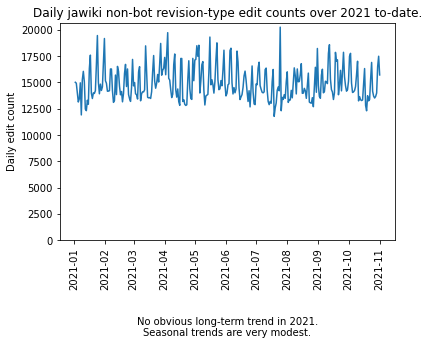

In [11]:
day_data['each_day'].plot()
plt.xticks(rotation=90)
plt.title('Daily jawiki non-bot revision-type edit counts over 2021 to-date.')
plt.xlabel('\n\n'
           'No obvious long-term trend in 2021.\n'
           'Seasonal trends are very modest.')
plt.ylabel('Daily edit count')
plt.ylim(0,)
plt.show()

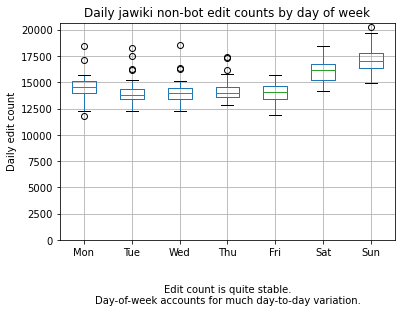

In [12]:
(day_data
 [['Mon','Tue','Wed','Thu','Fri','Sat','Sun']]
 .replace(0, np.nan)
 .boxplot()
)
plt.title('Daily jawiki non-bot edit counts by day of week')
plt.xlabel('\n\n'
           'Edit count is quite stable.\n'
           'Day-of-week accounts for much day-to-day variation.')
plt.ylabel('Daily edit count')
plt.ylim(0,)
plt.show()

### Count Edits by Hour, Weekday

In [13]:
df['hour'] = df.t_ja.dt.hour

In [14]:
total_days = (df.ymd.max() - df.ymd.min()).days
hour_data = (
    df.groupby('hour')
    .sum()
    .sort_index()
    [['Mon','Tue','Wed','Thu','Fri','Sat','Sun']]
    .divide(total_days/7)
)

### Plot edits by Hour, Weekday

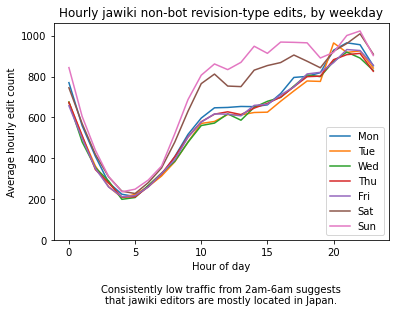

In [15]:
hour_data.plot()
plt.title('Hourly jawiki non-bot revision-type edits, by weekday')
plt.xlabel('Hour of day\n'
           '\n'
           'Consistently low traffic from 2am-6am suggests\n'
           'that jawiki editors are mostly located in Japan.')
plt.ylabel('Average hourly edit count')
plt.ylim(0,)
plt.show()

### Get Japan's holidays

In [16]:
# all_holidays includes observed-holidays, weekend holidays, and weekday holidays
all_holidays = pd.read_csv(
    home_path + '/git/predwikt/data/external/Japan_holidays.tsv', 
    delimiter='\t', usecols = ['Date', 'Name', 'Type'])
all_holidays['Date'] = (
    all_holidays.Date
    .apply(lambda x: pd.to_datetime(x, format='%d %b'))
    .apply(lambda x: x.replace(year = 2021))
)
all_holidays['Weekday'] = all_holidays.Date.dt.weekday.map(weekdays_dict)

In [17]:
# Select only weekday-holidays
holidays = all_holidays[all_holidays.Type == 'National holiday']
holidays = holidays[['Date', 'Name', 'Type']]
holidays = holidays.rename(columns={'Name':'holiday_name'})
# Remove time portion of datatype
holidays['index'] = holidays.Date.dt.date
holidays = holidays.set_index('index', drop=True)

In [18]:
# Add column with time portion of datetime removed
df['Date'] = df.t_ja.dt.date

In [19]:
# Merge holidays into full time series
df = df.merge(
    holidays.loc[:, 'holiday_name'], 
    how='left', left_on='Date', right_index=True)
# Get holiday dummy variable
df['holiday'] = df.holiday_name.notnull()

In [20]:
# Check if there are any nulls in dataset (other than the columns that use nulls on purpose)
df[df.columns.difference(['holiday_name', 'event_user_is_bot_by_historical'])].isnull().any().any()

False

In [21]:
# Count the holidays in the dataset
num_holidays = df[['Date', 'holiday']].loc[df.holiday == True].drop_duplicates().count()[0]
num_holidays

13

In [22]:
# Get hourly edit-counts averaged over holidays only
hour_data_holidays = (
    df.loc[df.holiday]
    .groupby('hour')
    .sum()
    .loc[:,'holiday']
    .sort_index()
    .divide(num_holidays)
    .rename('National Holidays on Weekdays')
)

### Plot Edits on Holidays

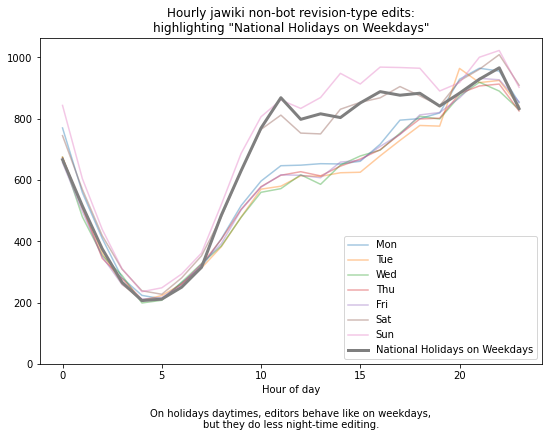

In [23]:
fig = plt.figure(figsize=(9,6))
ax = fig.gca()
hour_data.plot(ax=ax, alpha=.4)
hour_data_holidays.plot(ax=ax, linewidth=3)  # new untested edit
ax.set_title('Hourly jawiki non-bot revision-type edits:\n'
             'highlighting "National Holidays on Weekdays"')
ax.set_xlabel('Hour of day\n'
              '\n'
              'On holidays daytimes, editors behave like on weekdays,\n'
              'but they do less night-time editing.')
ax.set_label('Average hourly edit count')
ax.set_ylim(0,)
ax.legend()
plt.show()

## Check correlation with lagged edits

### Prep data for regression

In [24]:
# Get a holiday dummy into day_data
days_holidays = (
    day_data
    .join(holidays.holiday_name)
    .assign(holiday=lambda x: x.holiday_name.notnull().astype(int))
    .drop(columns='holiday_name')
)

In [25]:
# Turn weekdays into dummies
# This is hacky but it's just initial EDA
days_holidays[['Mon','Tue','Wed','Thu','Fri','Sat','Sun']] = (
    days_holidays[['Mon','Tue','Wed','Thu','Fri','Sat','Sun']]
    .astype(bool).astype(int)
)

In [26]:
# Get a column for 1-day-lagged revision count
days_holidays.rename(columns={'each_day':'revisions'}, inplace=True)
days_holidays['lag_revisions'] = days_holidays.revisions.shift(-1)

### Prep regression variables

In [27]:
ss = StandardScaler()

In [28]:
# Partition days_holidays into X and y for regression
y = days_holidays['revisions']
X = days_holidays.loc[:, days_holidays.columns.difference(['revisions'])]
X_columns = X.columns

# Drop the last observation (observation incomplete because of lag)
X = X.iloc[:-1]
y = y.iloc[:-1]

In [29]:
# Normalize lagged revisions
X['lag_revisions'] = ss.fit_transform(X.lag_revisions.to_frame())

# Append a constant term
X = sm.add_constant(X)

# Drop Monday (because collinear with constant)
X = X.drop('Mon', axis=1)

# Reorder columns
X = X[['lag_revisions','holiday','Tue','Wed','Thu','Fri','Sat','Sun','const']]

### Regress in statsmodels

In [30]:
mdl = sm.OLS(y, X)
rslt = mdl.fit()

pd.DataFrame({'var':X.columns,'coeff':rslt.params.round(1), 'stderr':rslt.bse.round(1)})

,var,coeff,stderr
lag_revisions,lag_revisions,658.9,76.8
holiday,holiday,2100.8,269.4
Tue,Tue,-329.7,193.5
Wed,Wed,-327.7,194.2
Thu,Thu,-230.7,193.1
Fri,Fri,-1177.2,219.4
Sat,Sat,559.3,247.4
Sun,Sun,2770.3,195.0
const,const,14637.8,145.2


In [31]:
# lr = LinearRegression(fit_intercept=False)
# lr.fit(X, y)
# print(f'R² = {lr.score(X,y).round(1)}')
# pd.DataFrame({'var':X.columns,'coeff':lr.coef_.round(1)})